In [446]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [447]:
# install and import necessary libraries.

#pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

import matplotlib.pyplot as plt 
import seaborn as sns 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Load dataset**

In [448]:
data = pd.read_csv('/content/drive/My Drive/Greater_Learning /NLP Project /Tweets.csv')

In [449]:
data.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


**Print Shape of data**

In [450]:
data.shape

(14640, 15)

**data description**

In [451]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

'text' column and 'airline_sentiment' columnes are the major focus and from the data provided they don't have missing values as the number of rows with non-null is the same

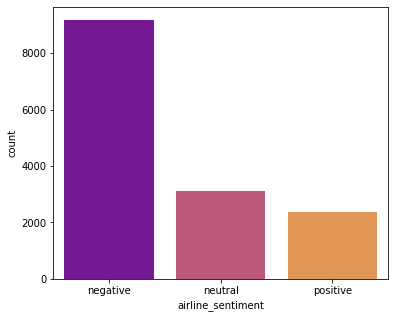

In [452]:
plt.figure(figsize=(6,5))
sns.countplot(data['airline_sentiment'], order =data.airline_sentiment.value_counts().index,palette= 'plasma')
plt.show()



There are more negative sentiments than other expressions of sentiment. The non-balanced nature would be noted incase of model improvement

We can also have a full view of how the sentiments varies with the type of airlines available 

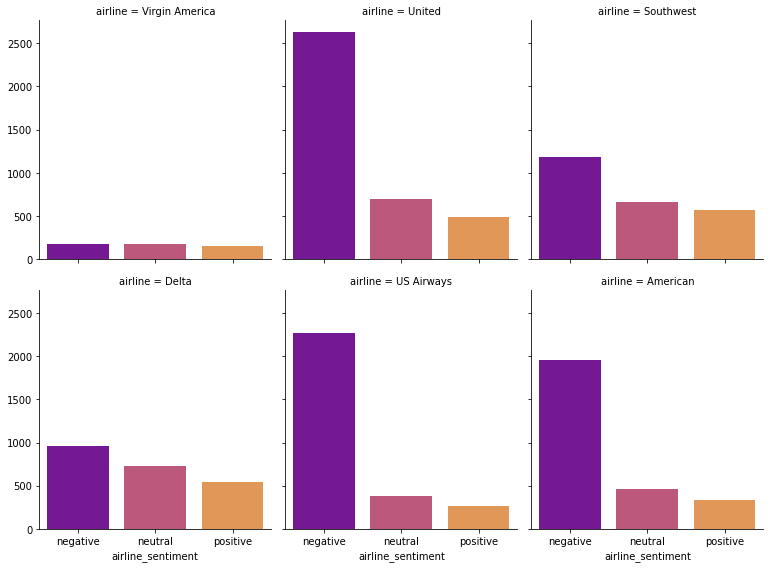

In [453]:
A = sns.FacetGrid(data, col= 'airline', col_wrap=3, height=4, aspect =0.9) 
A = A.map(sns.countplot, 'airline_sentiment', 
          order =data.airline_sentiment.value_counts().index, palette='plasma') 
plt.show()

The overall general contribution of negative review is coming more from 'US Airways', and 'American airline' as their sentiments are hugely negative 

In [454]:
data.describe()   #description of numerical attributes (general info)

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


### **Understand of data-columns**

**Drop all other columns except 'text' and 'airline_sentiment'**

In [455]:
labels = data.columns.to_list() 
labels

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [456]:
df = data.drop(['tweet_id',
                'airline_sentiment_confidence',
                'negativereason',
                'negativereason_confidence',
                'airline',
                'airline_sentiment_gold',
                'name',
                'negativereason_gold',
                'retweet_count',
                'tweet_coord',
                'tweet_created',
                'tweet_location',
                'user_timezone'], axis =1)

**print new shape**

In [457]:
df.shape

(14640, 2)

**Print first five rows**

In [458]:
pd.set_option('display.max_colwidth', None)  # view full length of strings 

In [459]:
print(df.head())

  airline_sentiment                                                                                                                            text
0           neutral                                                                                             @VirginAmerica What @dhepburn said.
1          positive                                                        @VirginAmerica plus you've added commercials to the experience... tacky.
2           neutral                                                         @VirginAmerica I didn't today... Must mean I need to take another trip!
3          negative  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4          negative                                                                         @VirginAmerica and it's a really big bad thing about it


### **Text pre-processing: Data preparation**

**Html tag removal** 

In [460]:
#Function to remove html tags
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()
df['text'] = df['text'].apply(lambda x: remove_html(x))
df.head(2)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.


**Remove special characters**

In [461]:
# function to remove special characters
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'  # remove non-alphanumeric characters
    return re.sub(pat, '', text)
df['text'] = df['text'].apply(lambda x: remove_special_characters(x)) 
df.head(2)

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said.
1,positive,VirginAmerica plus you've added commercials to the experience... tacky.


**Remove Numbers**

In [462]:
# function to remove numbers
def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)
df['text'] = df['text'].apply(lambda x: remove_numbers(x))   
df.head(3)

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said.
1,positive,VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,VirginAmerica I didn't today... Must mean I need to take another trip!


**Remove Punctuations**

In [463]:
# function to remove punctuation
def remove_punctuation(text):
    text = ''.join([c for c in text if c not in string.punctuation])
    return text
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))    
df.head(3)   

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus youve added commercials to the experience tacky
2,neutral,VirginAmerica I didnt today Must mean I need to take another trip


**Replace contractions in string. (e.g. replace I'm --> I am) and so on.**

In [464]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

df['text'] = df['text'].apply(lambda x: replace_contractions(x))
df.head()

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you have added commercials to the experience tacky
2,neutral,VirginAmerica I did not today Must mean I need to take another trip
3,negative,VirginAmerica its really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,VirginAmerica and its a really big bad thing about it


**Conversion to Lowercase**

In [465]:
def to_lowercase(text):
    return text.lower()
df['text'] = df['text'].apply(lambda x: to_lowercase(x))  
df.head(2)

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you have added commercials to the experience tacky


**Tokenization**

In [466]:
#tokenization
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
df.head(2)

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]"


**Lemmatization**

In [467]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words
df['text'] = df['text'].apply(lambda x: lemmatize_list(x)) 
df.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, say]"
1,positive,"[virginamerica, plus, you, have, add, commercials, to, the, experience, tacky]"
2,neutral,"[virginamerica, i, do, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[virginamerica, its, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, face, they, have, little, recourse]"
4,negative,"[virginamerica, and, its, a, really, big, bad, thing, about, it]"


**Join words**

In [468]:
def normalize(words):
    words = lemmatize_list(words)
    return ' '.join(words)

**Print first five rows**

In [469]:
df['text'] = df['text'].apply(lambda x: normalize(x)) 
print(df.head())

  airline_sentiment                                                                                                                text
0           neutral                                                                                     virginamerica what dhepburn say
1          positive                                                 virginamerica plus you have add commercials to the experience tacky
2           neutral                                                  virginamerica i do not today must mean i need to take another trip
3          negative  virginamerica its really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4          negative                                                               virginamerica and its a really big bad thing about it


### **Vectorization**

**Using Count Vectorizer**

In [470]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)                # Keep only 1000 features as number of features will increase the processing time.
Vec_features = vectorizer.fit_transform(df['text'])

Vec_features = Vec_features.toarray()                        # Convert the data features to array.
print(Vec_features.shape)
print(Vec_features)

(14640, 1000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]


**Using TfidfVectorizer**

In [471]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer1 = TfidfVectorizer(max_features=1000)
Tfidf_features = vectorizer1.fit_transform(df['text'])

Tfidf_features = Tfidf_features.toarray()

print(Tfidf_features.shape)
print(Tfidf_features)

(14640, 1000)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.17706013 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


*lebel encode the target variable = airline sentiment*

In [472]:
replace_cat = { 'airline_sentiment': {'neutral': 0, 'positive':1 , 'negative': -1}  } # respecting the percieved order of sentiment
df=df.replace(replace_cat) 
df.head()

,airline_sentiment,text
0,0,virginamerica what dhepburn say
1,1,virginamerica plus you have add commercials to the experience tacky
2,0,virginamerica i do not today must mean i need to take another trip
3,-1,virginamerica its really aggressive to blast obnoxious entertainment in your guests face they have little recourse
4,-1,virginamerica and its a really big bad thing about it


*define the labels for training*

In [473]:
labels = df['airline_sentiment']
labels = labels.astype('int')

**Training a Random Forest Model Using Count Vectorizer applied to the features**

*Split data into training and testing*

In [474]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Vec_features, labels, test_size=0.3, random_state=42)
X_train.shape, y_train.shape

((10248, 1000), (10248,))

In [475]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score,accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [476]:
# Predict the result for test data using the model built above.

result = forest.predict(X_test)

Text(0.5, 42.0, 'Predicted label')

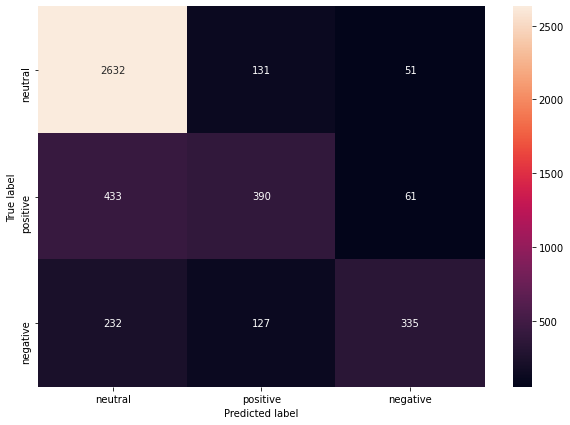

In [477]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sentiment = data['airline_sentiment'].unique().tolist()

cm = confusion_matrix(y_test, result)
df_cm = pd.DataFrame(cm, index = [i for i in sentiment],
                     columns = [i for i in sentiment])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

*Evaluation of Count Vectorizer method*

In [478]:
print("Trainig accuracy",forest.score(X_train,y_train))  
print()
print("Testing accuracy",forest.score(X_test, y_test))
print()
print("Validation Score", np.mean(cross_val_score(forest, Vec_features, labels, cv=10)))
print(classification_report(y_test, result))

Trainig accuracy 0.9787275565964091

Testing accuracy 0.764344262295082

Validation Score 0.7187841530054645
              precision    recall  f1-score   support

          -1       0.80      0.94      0.86      2814
           0       0.60      0.44      0.51       884
           1       0.75      0.48      0.59       694

    accuracy                           0.76      4392
   macro avg       0.72      0.62      0.65      4392
weighted avg       0.75      0.76      0.75      4392



**Training a Random Forest Model Using TfidfVectorizer applied to the features**

In [479]:
X1_train, X1_test, y1_train, y1_test = train_test_split(Tfidf_features, labels, test_size=0.3, random_state=42)
X1_train.shape, y1_train.shape

((10248, 1000), (10248,))

In [480]:
forest1 = RandomForestClassifier(n_estimators=10, n_jobs=4)
forest1 = forest1.fit(X1_train, y1_train)
print(forest1)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [481]:
result1 = forest1.predict(X_test)

Text(0.5, 42.0, 'Predicted label')

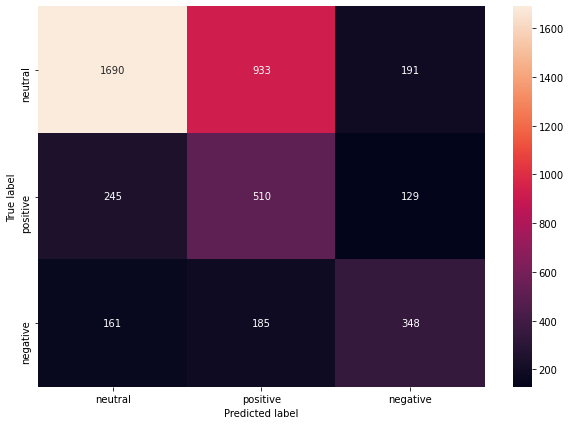

In [482]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

sentiment = data['airline_sentiment'].unique().tolist()

cm = confusion_matrix(y1_test, result1)
df_cm = pd.DataFrame(cm, index = [i for i in sentiment],
                     columns = [i for i in sentiment])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')

*Evaluation of TfidfVectorizer method*

In [483]:
print("Trainig accuracy",forest1.score(X1_train,y1_train))  
print()
print("Testing accuracy",forest1.score(X1_test, y1_test))
print()
print("Validation Score", np.mean(cross_val_score(forest1, Tfidf_features, labels, cv=10)))
print(classification_report(y1_test, result1))

Trainig accuracy 0.9795081967213115

Testing accuracy 0.755464480874317

Validation Score 0.7117486338797815
              precision    recall  f1-score   support

          -1       0.81      0.60      0.69      2814
           0       0.31      0.58      0.41       884
           1       0.52      0.50      0.51       694

    accuracy                           0.58      4392
   macro avg       0.55      0.56      0.54      4392
weighted avg       0.66      0.58      0.60      4392



**Summarizing my understanding of the application of Various Pre-processing and Vectorization and performance of my model on this dataset**

Observations: 


*   Both count vectorizer (CVec) model and TfidfVectorizer (Tfidf) model showed good training and testing accuracy 
*   While Tfidf model showed higher training accuracy, the testing accuracy is lower than CVec model
*   Precision and recall are generally higher using CVec model than Tfidf model 
*   F1 score also showed that CVec model was effective in the classification than Tfidf model 

---


**Generaly in terms of model performance, the Cvec model seems to perform better than the Tfidf model for this specific tweet sentiment analysis task** 



Based on this project, the following deduction can be made:


 **Must Do**:

---


*   Noise removal (e.g punctuation, Html tag, special character etc must be removed for good model training)



**Should Do:**

---


*   Stemming and Lemmatization
*   Lowercasing of text
